<a href="https://colab.research.google.com/github/Mayakshanesht/Semantic-Segmentation/blob/main/Copy_of_Semantic_segmentation_version3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#lets mount drive on the google colab
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/segmentation/segmentation_course-master/dataset/dataset")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
costa_rica_challenge.mp4  masks_3000_160.p	SegmentationTest.h5
images_3000_160.p	  model.png
labels_3000_160.p	  SegmentationTest2.h5


In [2]:
#lets import important python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import cv2
import random
import time
#lets install tensorflow
import tensorflow as tf
print(tf.__version__)

2.6.0


In [3]:
with open('images_3000_160.p','rb') as f:
  images=pickle.load(f)
with open('labels_3000_160.p','rb') as f:
  labels=pickle.load(f) 

In [4]:
masks=[]
for label in labels:
  for x in range(label.shape[0]):
    for y in range(label.shape[1]):
      if(np.all(label[x][y]==[0,0,0])):
        label[x][y]=[0,1,0]
        masks.append(label)

In [ ]:
#file="masks_3000_160.p"
#pickle.dump(masks, open(file, "wb"))
#(masks,'masks_3000_160.p')

In [ ]:
#with open('masks_3000_160.p','rb') as f:
#  masks=pickle.load(f) 

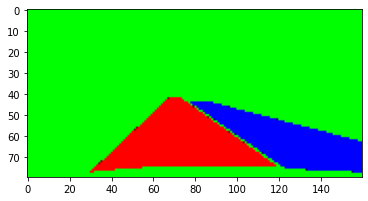

In [5]:
#masks=labels
plt.imshow(masks[3])
plt.show()

In [ ]:
#images=(np.array(images[0:2999]))
#images1=np.array(images[0:2999])
#masks=(np.array(masks[0:2999]))

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
from scipy import io
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt 

In [ ]:
#1-Ignore
base = keras.applications.DenseNet121(input_shape=[128,128,3], 
                                       include_top=False, 
                                       weights='imagenet')
skip_names = ['conv1/relu', # size 64*64
              'pool2_relu',  # size 32*32
              'pool3_relu',  # size 16*16
              'pool4_relu',  # size 8*8
              'relu'        # size 4*4
              ] 
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
     print(skip_outputs[i]) 
downstack = keras.Model(inputs=base.input,
                        outputs=skip_outputs)
downstack.trainable = False 
!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
 # Four upstack blocks for upsampling sizes 
 # 4->8, 8->16, 16->32, 32->64 
upstack = [pix2pix.upsample(512,3),
           pix2pix.upsample(256,3),
           pix2pix.upsample(128,3),
           pix2pix.upsample(64,3)] 
# define the input layer
inputs = keras.layers.Input(shape=[128,128,3])
 # downsample 
down = downstack(inputs)
out = down[-1]
 # prepare skip-connections
skips = reversed(down[:-1])
 # choose the last layer at first 4 --> 8
 # upsample with skip-connections
for up, skip in zip(upstack,skips):
     out = up(out)
     out = keras.layers.Concatenate()([out,skip])
 # define the final transpose conv layer
 # image 128 by 128 with 59 classes
out = keras.layers.Conv2DTranspose(3, 3,
                                   strides=2,
                                   padding='same',
                                   )(out)
 # complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [ ]:
def resize_image(image):
     image = tf.cast(image, tf.float32)
     # scale values to [0,1]
     image = image/255.0
     # resize image
     image = tf.image.resize(image, (128,128))
     return image 
def resize_mask(mask):
     #mask = tf.expand_dims(mask, axis=-1)
     mask = tf.image.resize(mask, (128,128))
     mask = tf.cast(mask, tf.uint8)
     return mask 
X = np.array([resize_image(i) for i in images])
y = np.array([resize_mask(m) for m in masks])

In [ ]:
X.shape

In [ ]:
from sklearn.model_selection import train_test_split
train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                       test_size=0.2, 
                                                       random_state=0
                                                      )

In [ ]:
len(val_X)

600

In [ ]:
#2-Ignore
unet.compile(loss= keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
             metrics=['accuracy']) 

In [ ]:
#https://github.com/zhixuhao/unet/blob/master/data.py
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(input_size = (128,128,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(3, 1, activation = 'softmax')(conv9)

    model =Model(inputs = inputs, outputs = conv10)

    
    
    #model.summary()

    #if(pretrained_weights):
    #	model.load_weights(pretrained_weights)

    return model
unet=unet()
unet.summary()

In [ ]:
unet.compile(loss= 'CategoricalCrossentropy',
             optimizer='Adam',
             metrics=['accuracy']) 

In [ ]:
unet.fit(train_X,train_y,epochs=2,validation_data=(val_X,val_y))

In [ ]:
def rgb_channel(img, thresholding=False, thresh=130):
    """Threshold the re-drawn images"""
    image = np.copy(img)
    if thresholding:
        ret, image = cv2.threshold(image, thresh, 255,cv2.THRESH_BINARY)
    R = image[:,:,0]
    G =image[:,:,1]
    B =image[:,:,2]
    return R,G,B

In [ ]:
#from tensorflow import keras
#model = keras.models.load_model("/content/drive/My Drive/segmentation/semantic_segmentation3.h5")

In [ ]:
def run(input_image):
    h,w,d = input_image.shape

    network_image = input_image.copy()
    network_image = cv2.resize(network_image, (128,128), interpolation=cv2.INTER_AREA)
    network_image=resize_image(network_image)
    network_image = network_image[None,:,:,:]
    prediction = unet.predict(network_image)[0]*255
    R,G,B = rgb_channel(prediction)
    blank = np.zeros_like(R).astype(np.uint8)
    lane_image = np.dstack((R,blank,B))
    lane_image = cv2.resize(lane_image, (w,h))
    result = cv2.addWeighted(input_image, 1, lane_image.astype(np.uint8), 1, 0)
    return result

In [ ]:
unet.save("/content/drive/My Drive/segmentation/semantic_segmentation_unet11.h5")

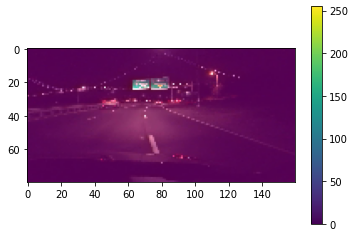

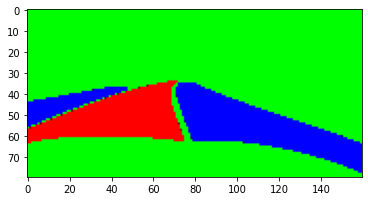

In [ ]:
idx=2
predict_image = images[idx]
img=run(predict_image)
plt.imshow(img)
plt.colorbar()
plt.show()
plt.imshow((labels[idx]))

plt.show()

In [ ]:
from moviepy.editor import VideoFileClip

video_file = "/content/drive/My Drive/segmentation/segmentation_course-master/dataset/dataset/costa_rica_challenge.mp4"
clip = VideoFileClip(video_file)
white_clip = clip.fl_image(run)
%time white_clip.write_videofile("/content/drive/My Drive/segmentation/movie_track51.mp4",audio=False)